# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [4]:
rect_start = None
rect_end = None
drawing = False

In [5]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [6]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [8]:
coord = interactive_bbox_selection("frames/frame_0000.png")

Coordinates: [165, 89, 1033, 1598]


### Segment image based on rectangle coordinates


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4251.6ms
Speed: 7.5ms preprocess, 4251.6ms inference, 80.9ms postprocess per image at shape (1, 3, 640, 640)


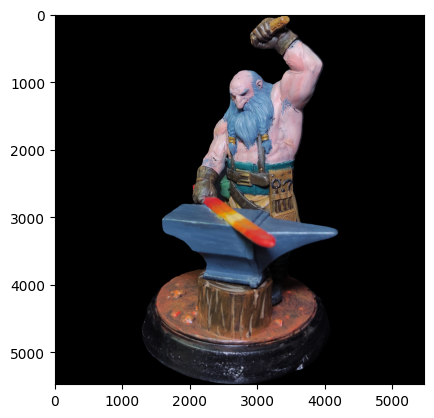

In [9]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [8]:
def segmenting_image(coordinates, model, source):
    results = model(source,
                    device="cuda",
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

Coordinates: [192, 108, 938, 1670]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)


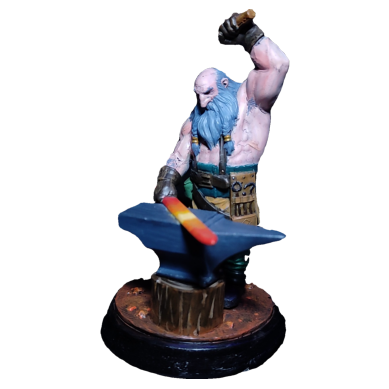

In [9]:
from ultralytics import SAM
%matplotlib inline

rect_start = None
rect_end = None
drawing = False

source = "frames/frame_0073.png"
model = SAM("models/sam_l.pt")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source)

## 3D reconstruction from videos

### Extract segmented frames from Video

In [25]:
import torch
import numpy as np
import os
from tqdm import tqdm

# Segment in every frame
def segmenting_image(folder, coordinates, model):

    for file in tqdm(os.listdir(folder), "Segmenting images"):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        results = model.predict(os.path.join(folder, file),
                                device=device,
                                imgsz=1024,
                                bboxes=coordinates,
                                conf=0.25)
        
        for result in results:
            img = np.copy(result.orig_img)
            for ci, c in enumerate(result):
                b_mask = np.zeros(img.shape[:2], np.uint8)

                # Create contour mask 
                contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
                cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

                res = cv2.bitwise_and(img, img, mask=b_mask)
                
                contour = contour.reshape(-1, 2)
                x_min, y_min = np.min(contour, axis=0)
                x_max, y_max = np.max(contour, axis=0)
                
                # Crop the image to get only the segmented object
                cropped_image = res[y_min:y_max, x_min:x_max]
                cv2.imwrite(os.path.join(os.path.join(folder, file)), cropped_image)

In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_interval=30):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0
    
    # Get rotation information
    rotation = int(cap.get(cv2.CAP_PROP_ORIENTATION_META))
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Extracting features...")
    with tqdm(total=total_frames, unit="frame") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation correction based on metadata
            if rotation == 90:
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 180:
                frame = cv2.rotate(frame, cv2.ROTATE_180)
            elif rotation == 270:
                frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
            # Save frame
            if frame_count % frame_interval == 0:
                frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.png")

                cv2.imwrite(frame_filename, frame)
                
                extracted_count += 1
            
            frame_count += 1
            pbar.update(1)
        cap.release()

In [23]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def extract_features(image_path, detector='sift'):
    """Extract keypoints and descriptors using FLANN-compatible feature detector"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None
    
    # Choose detector
    if detector == 'sift':
        feature_detector = cv2.SIFT_create()
    elif detector == 'orb':
        feature_detector = cv2.ORB_create(nfeatures=1000)
    else:
        raise ValueError("Use 'sift' or 'orb' as detector")
    
    kp, des = feature_detector.detectAndCompute(img, None)
    return kp, des

def flann_matcher(des1, des2, ratio_thresh=0.7):
    """FLANN-based feature matching with Lowe's ratio test"""
    if des1 is None or des2 is None:
        return 0
    
    # FLANN parameters (adjust for ORB/SIFT)
    if des1.dtype == np.uint8:  # ORB
        flann = cv2.FlannBasedMatcher(
            dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1), 
            dict(checks=50)
        )
    else:  # SIFT
        flann = cv2.FlannBasedMatcher(
            dict(algorithm=1, trees=5), 
            dict(checks=50)
        )
    
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    return len(good_matches)

def find_duplicates_flann(image_folder, min_matches=80, delete=False):
    """Find duplicates using FLANN feature matching"""
    image_files = [f for f in os.listdir(image_folder) 
                  if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    features = {}
    duplicates = set()

    print("Extracting features...")
    for filename in tqdm(image_files):
        filepath = os.path.join(image_folder, filename)
        kp, des = extract_features(filepath, detector='sift')  # Try 'orb' for faster but less accurate
        if des is not None:
            features[filename] = des

    print("\nComparing images with FLANN...")
    processed = set()
    for file1 in tqdm(features.keys()):
        if file1 in processed:
            continue
            
        group = {file1}
        for file2 in features.keys():
            if file1 != file2 and file2 not in processed:
                matches = flann_matcher(features[file1], features[file2])
                if matches > min_matches:
                    group.add(file2)
        
        if len(group) > 1:
            # Keep the highest resolution image from duplicates
            keep = max(group, key=lambda x: os.path.getsize(os.path.join(image_folder, x)))
            for dup in group:
                if dup != keep:
                    duplicates.add(dup)
        
        processed.update(group)

    print(f"\nFound {len(duplicates)} duplicates:")

    if delete:
        for dup in duplicates:
            os.remove(os.path.join(image_folder, dup))
        print(f"Deleted duplicates.")
    else:
        print("\nDuplicates NOT deleted (run with delete=True to remove)")

    return list(duplicates)

In [26]:
from ultralytics import SAM
from tqdm import tqdm

model = SAM("models/sam2_l.pt")
coordinates = [165, 89, 1033, 1598]

extract_frames("test_video.mp4", "frames", 30)
find_duplicates_flann("frames", min_matches=500, delete=True)
segmenting_image("frames", coordinates, model)

Extracting Frames: 100%|██████████| 943/943 [00:09<00:00, 99.00frame/s] 


Extracting features...


100%|██████████| 32/32 [00:17<00:00,  1.88it/s]



Comparing images with FLANN...


100%|██████████| 32/32 [00:25<00:00,  1.26it/s]



Found 8 duplicates:
Deleted duplicates.


Segmenting images:   0%|          | 0/24 [00:00<?, ?it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0000.png: 1024x1024 1 0, 2072.3ms
Speed: 151.4ms preprocess, 2072.3ms inference, 89.3ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:   4%|▍         | 1/24 [00:03<01:09,  3.02s/it]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0004.png: 1024x1024 1 0, 417.7ms
Speed: 6.3ms preprocess, 417.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:   8%|▊         | 2/24 [00:03<00:33,  1.55s/it]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0005.png: 1024x1024 1 0, 419.8ms
Speed: 6.1ms preprocess, 419.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  12%|█▎        | 3/24 [00:04<00:22,  1.07s/it]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0007.png: 1024x1024 1 0, 451.6ms
Speed: 10.5ms preprocess, 451.6ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  17%|█▋        | 4/24 [00:04<00:17,  1.14it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0008.png: 1024x1024 1 0, 439.4ms
Speed: 7.0ms preprocess, 439.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  21%|██        | 5/24 [00:05<00:14,  1.34it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0009.png: 1024x1024 1 0, 421.0ms
Speed: 6.2ms preprocess, 421.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  25%|██▌       | 6/24 [00:05<00:12,  1.50it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0010.png: 1024x1024 1 0, 421.0ms
Speed: 6.2ms preprocess, 421.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  29%|██▉       | 7/24 [00:06<00:10,  1.63it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0011.png: 1024x1024 1 0, 429.0ms
Speed: 6.7ms preprocess, 429.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  33%|███▎      | 8/24 [00:06<00:09,  1.71it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0012.png: 1024x1024 1 0, 430.3ms
Speed: 5.9ms preprocess, 430.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  38%|███▊      | 9/24 [00:07<00:08,  1.78it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0013.png: 1024x1024 1 0, 432.1ms
Speed: 6.6ms preprocess, 432.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  42%|████▏     | 10/24 [00:07<00:07,  1.80it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0014.png: 1024x1024 1 0, 422.5ms
Speed: 9.2ms preprocess, 422.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  46%|████▌     | 11/24 [00:08<00:07,  1.84it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0015.png: 1024x1024 1 0, 424.7ms
Speed: 8.6ms preprocess, 424.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  50%|█████     | 12/24 [00:08<00:06,  1.84it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0016.png: 1024x1024 1 0, 420.7ms
Speed: 7.2ms preprocess, 420.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  54%|█████▍    | 13/24 [00:09<00:05,  1.84it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0017.png: 1024x1024 1 0, 428.0ms
Speed: 5.8ms preprocess, 428.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  58%|█████▊    | 14/24 [00:09<00:05,  1.87it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0018.png: 1024x1024 1 0, 431.5ms
Speed: 9.9ms preprocess, 431.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  62%|██████▎   | 15/24 [00:10<00:04,  1.85it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0019.png: 1024x1024 1 0, 426.7ms
Speed: 15.7ms preprocess, 426.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  67%|██████▋   | 16/24 [00:10<00:04,  1.85it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0020.png: 1024x1024 1 0, 431.3ms
Speed: 8.9ms preprocess, 431.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  71%|███████   | 17/24 [00:11<00:03,  1.85it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0021.png: 1024x1024 1 0, 428.4ms
Speed: 5.8ms preprocess, 428.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  75%|███████▌  | 18/24 [00:12<00:03,  1.85it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0022.png: 1024x1024 1 0, 421.2ms
Speed: 7.7ms preprocess, 421.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  79%|███████▉  | 19/24 [00:12<00:02,  1.88it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0023.png: 1024x1024 1 0, 429.5ms
Speed: 6.1ms preprocess, 429.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  83%|████████▎ | 20/24 [00:13<00:02,  1.90it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0024.png: 1024x1024 1 0, 432.4ms
Speed: 6.1ms preprocess, 432.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  88%|████████▊ | 21/24 [00:13<00:01,  1.91it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0026.png: 1024x1024 1 0, 436.5ms
Speed: 8.9ms preprocess, 436.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  92%|█████████▏| 22/24 [00:14<00:01,  1.91it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0027.png: 1024x1024 1 0, 432.7ms
Speed: 6.3ms preprocess, 432.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images:  96%|█████████▌| 23/24 [00:14<00:00,  1.90it/s]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0031.png: 1024x1024 1 0, 422.5ms
Speed: 9.8ms preprocess, 422.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


Segmenting images: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


### Building 3D models from 2D images

#### Libraries import

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torch
import numpy as np
import open3d as o3d
import glob
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Getting Model

In [2]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### Loading and resizing the image

In [4]:
image = Image.open("frames/frame_0000.png")

new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32

new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

#### Preparing the image for the model

In [5]:
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

#### Getting the prediction

In [6]:
with torch.no_grad():
    outputs = model(**inputs)
    
predicted_depth = feature_extractor.post_process_depth_estimation(
    outputs, target_sizes=[(image.height, image.width)],
)

#### Post-processing

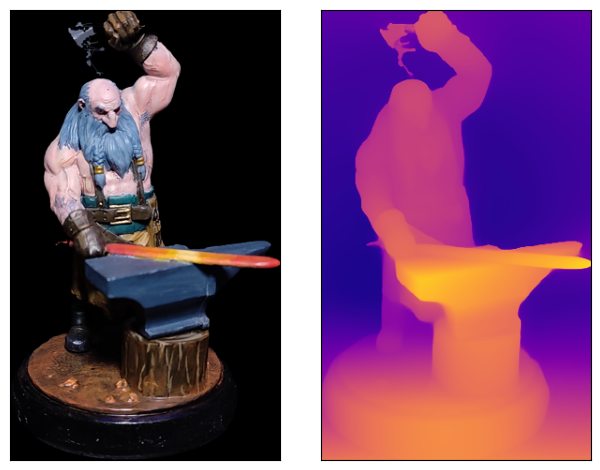

In [ ]:
depth = predicted_depth[0]["predicted_depth"]
depth = (depth - depth.min()) / (depth.max() - depth.min())
depth = depth * 255.
depth = depth.detach().cpu().numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft = False, labelbottom=False)
ax[1].imshow(depth, cmap="plasma")
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.show()

#### Preparing the depth image for open3d

In [8]:
width, height = image.size

depth_image = (depth * 255 / np.max(depth)).astype('uint8')
image = np.array(image)

depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,
                                                                depth_o3d,
                                                                convert_rgb_to_intensity=False)

#### Creating a camera

In [ ]:
# Define the dimensions of checkerboard
chessboard_size = (7, 6)
square_size = 2.5

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size  # Convert to real world units

# Arrays to store object points and image points
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Get list of calibration images
images = glob.glob("calibration_images/*.jpg")

for fname in images:
    print(f"Processing {fname}")
    
    # Read the image
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(
        gray, 
        chessboard_size, 
        None
    )
    
    # If found, refine the corners
    if ret:
        print("Chessboard found!")
        
        # Refine corner positions
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        
        # Add to our collections
        objpoints.append(objp)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        img_corners = cv2.drawChessboardCorners(img.copy(), chessboard_size, corners2, ret)
        
        # Display the result
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
        plt.title(f"Chessboard Corners: {fname}")
        plt.show()
    else:
        print(f"No Chessboard Found in {fname}")
        
        # Display the original image for debugging
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Failed Detection: {fname}")
        plt.show()

In [ ]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

if ret:
    print("Camera calibration successful!")
    print("Intrinsic matrix (mtx):")
    print(mtx)
    print("Distortion coefficients (dist):")
    print(dist)

    # Extract intrinsic parameters
    fx = mtx[0, 0]
    fy = mtx[1, 1]
    cx = mtx[0, 2]
    cy = mtx[1, 2]

    print(f"Focal length (fx, fy): ({fx}, {fy})")
    print(f"Optical center (cx, cy): ({cx}, {cy})")
else:
    print("Camera calibration failed. Check your input data.")

In [15]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

#### Creating o3d point cloud

In [16]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

#### Post-processing the 3D Point Cloud

In [19]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 2.0)
pcd = pcd.select_by_index(ind)

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd])

#### Surface reconstruction

In [20]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center = (0, 0, 0))

o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

#### 3D Mesh Export

In [28]:
o3d.io.write_triangle_mesh("test.obj", mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True

### Point clouds and RGBD images for all frames

In [ ]:
# Importing libraries
from PIL import Image
import torch
import numpy as np
import open3d as o3d
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import os
from tqdm import tqdm

# Getting Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

for image_path in tqdm(os.listdir("frames"), desc="Creating RGBD images and point clouds"):
    image = Image.open(os.path.join("frames", image_path))

    # Loading and resizing the image
    new_height = 480 if image.height > 480 else image.height
    new_height -= (new_height % 32)
    new_width = int(new_height * image.width / image.height)
    diff = new_width % 32

    new_width = new_width - diff if diff < 16 else new_width + 32 - diff
    new_size = (new_width, new_height)
    image = image.resize(new_size)

    # Preparing the image for the model
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    
    # Getting the prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    predicted_depth = feature_extractor.post_process_depth_estimation(
        outputs, target_sizes=[(image.height, image.width)],
    )

    # Post-processing
    depth = predicted_depth[0]["predicted_depth"]
    depth = (depth - depth.min()) / (depth.max() - depth.min())
    depth = depth * 255.
    depth = depth.detach().cpu().numpy()
    
    # Preparing the depth image for open3d
    width, height = image.size

    depth_image = (depth * 255 / np.max(depth)).astype('uint8')
    image = np.array(image)

    depth_o3d = o3d.geometry.Image(depth_image)
    image_o3d = o3d.geometry.Image(image)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,
                                                                    depth_o3d,
                                                                    convert_rgb_to_intensity=False)

    # Creating a camera
    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
    camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

    # Creating o3d point cloud
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
    
    # Post-processing the 3D Point Cloud
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 2.0)
    pcd = pcd.select_by_index(ind)

    pcd.estimate_normals()
    pcd.orient_normals_to_align_with_direction()
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    # Saving the point cloud
    o3d.io.write_point_cloud(os.path.join("point_clouds", os.path.splitext(image_path)[0]+".pcd"), pcd)

print("-------- All point clouds created --------")

### Dense Reconstruction

In [ ]:
from tqdm import tqdm
import os

def load_point_clouds(point_cloud_dir):
    """
    Load point clouds from a directory and preprocess them.
    
    Args:
        point_cloud_dir (str): Directory containing point cloud files
    
    Returns:
        list: Preprocessed point clouds
    """

    point_clouds = []
    point_cloud_files = sorted([file for file in os.listdir(point_cloud_dir) if file.endswith('.pcd')])
    
    for file in tqdm(point_cloud_files, desc="Loading point clouds"):
        pcd = o3d.io.read_point_cloud(os.path.join(point_cloud_dir, file))
        
        # Estimate normals for better ICP registration
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        point_clouds.append(pcd)
    
    return point_clouds

def register_point_clouds(point_clouds):
    """
    Sequentially register point clouds.
    
    Args:
        point_clouds (list): List of point clouds to register
    
    Returns:
        list: Aligned point clouds
    """
    ref_pcd = point_clouds[0]

    # 2. Align all other frames to the reference
    aligned_pcds = [ref_pcd]
    for pcd in tqdm(point_clouds[1:], "Registering Point Clouds"):
        # Run ICP (point-to-plane for better accuracy)
        reg_result = o3d.pipelines.registration.registration_icp(
            pcd, ref_pcd,
            max_correspondence_distance=0.05,  # Adjust based on object size
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane()
        )
        aligned_pcd = pcd.transform(reg_result.transformation)
        aligned_pcds.append(aligned_pcd)

    return aligned_pcds

def merge_point_clouds(aligned_pcds, voxel_size=0.0005):
    """
    Merge aligned point clouds and downsample.
    
    Args:
        aligned_pcds (list): List of aligned point clouds
        voxel_size (float): Voxel size for downsampling
    
    Returns:
        o3d.geometry.PointCloud: Merged and downsampled point cloud
    """
    merged_pcd = o3d.geometry.PointCloud()
    for pcd in tqdm(aligned_pcds, "Merging Point Clouds"):
        merged_pcd += pcd
    
    # Downsample to remove duplicates
    #merged_pcd = merged_pcd.voxel_down_sample(voxel_size)
    
    return merged_pcd

In [57]:
# Load point clouds
point_cloud_dir = "point_clouds"
point_clouds = load_point_clouds(point_cloud_dir)

# Register point clouds
aligned_pcds = register_point_clouds(point_clouds)

# Merge point clouds
merged_pcd = merge_point_clouds(aligned_pcds)

# Visualize or save
o3d.visualization.draw_geometries([merged_pcd])
# Uncomment to save
# o3d.io.write_point_cloud("merged_object.pcd", merged_pcd)

Merging Point Clouds: 100%|██████████| 28/28 [00:00<00:00, 83.76it/s]


In [ ]:
# Mesh reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(merged_pcd, depth=9)
o3d.visualization.draw_geometries([mesh])

## Pre-painting - coloring sketch

### Converting image to sketch

In [11]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ss = imageio.imread(img)
C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:31: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)


True

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

Text(value='', description='Text:', placeholder='Type something')

ColorPicker(value='#ff0000', description='Pick a color')

Button(description='Submit', icon='check', style=ButtonStyle(), tooltip='Click to submit text and color')

Button(description='Clear', icon='delete', style=ButtonStyle(), tooltip='Click to submit text and color')

Added: Ground with color #452e1c
Added: Shoe with color #97511c
Added: Guitar body with color #db7f39
Added: Guitar cord with color #747372
Added: Guitar horn with color #ffda8a
Added: Guitar tuner with color #eba000
Added: Socks with color #e81717
Added: Shoe detail with color #b67d02
Added: Shoe detail stripe with color #5c3db3
Added: Socks pearl with color #ffddc7
Added: Cloth bellow pearl with color #4d61ff
Added: Shin guard with color #58595a
Added: Shin guard detail with color #f4b734
Added: Pants with color #fbe7bc
Added: Pant stripes with color #369b8a
Added: Knife sheath with color #9058f9
Added: Waist stripes with color #000000
Added: Waist stripe tips with color #6f38d6
Added: Knife cord with color #cea969
Added: Knife metal with color #8b8479
Added: Knife gripper with color #69aae8
Added: Belt metal with color #788591
Added: Gloves with color #202122
Added: Cape with color #af2843
Added: Shirt with color #de1721
Added: Bodice with color #77181d
Added: Jacket with color #185

In [13]:
print(text_color_dict)

{}


### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)